<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Miscellaneous/Index_Pairwise_Correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Index Pairwise Correlations
---
### Initialize the Workspace
This is done by bringing in a standard library package, which you can find here [my_library.py](https://github.com/Farmhouse121/Financial-Data-Science-in-Python/blob/main/my_library.py). This needs to be imported into the workspace of the project, and then executed. For brevity, we also turn off `UserWarning` and `FutureWarning`. You can skip that step if you want to.

In [1]:
from my_library import *

15:11:09 Starting...
15:11:09 Installing yfinance into Google notebook...
15:11:16 Installing arch into Google notebook...
15:11:20 Initialized.


In [2]:
# let's ignore some warnings that clutter the output, skip this cell if you want to see them
from warnings import filterwarnings

for warning in UserWarning,FutureWarning:
    filterwarnings("ignore",category=warning)

### Store Results in a DataFrame for Meta-Analysis

In [3]:
try:
    raise Break # uncomment to reset meta dataframe
    display(meta:=pd.read_pickle("/content/drive/MyDrive/meta.pickle"))
    nprint("Read prior meta-analysis results from Google Drive.")

except:
    meta=pd.DataFrame({("Name","Filter"):[],"N":[],"N*":[],"rho":[]}).set_index(("Name","Filter"))
    nprint("Created empty DataFrame for meta-analysis results.")

15:11:20 Created empty DataFrame for meta-analysis results.


### Load List of Index Members
---
This has been set up to allow you to select one of the known indices by setting that value for `indexname`. In the future, more indices might be added via similar code branches.

In [5]:
nprint("Getting members of %s index." % (indexname:='FTSE 250')) # choose from'Dow','S&P 500','NASDAQ-100','S&P MidCap 400','S&P SmallCap 600','S&P 900','S&P 1500'

index,first_date=loadindex(indexname)
nprint("Total of %d stocks. First date for data extract is %s." % (index.shape[0],first_date))

15:13:24 Getting members of FTSE 250 index.


,Company,FTSE Industry Classification Benchmark sector[10]
Ticker,,
3IN.L,3i Infrastructure,Financial Services
FOUR.L,4imprint,Media
ABDN.L,Abrdn,Financial Services
APEO.L,abrdn Private Equity Opportunities Trust,Investment Trusts
ALFA.L,Alfa Financial Software,Software and Computer Services
...,...,...
WG.L,Wood Group,Oil & Gas Related Equipment and Services
WKP.L,Workspace Group,Real Estate Investment Trusts
WWH.L,Worldwide Healthcare Trust,Investment Trusts


15:13:25 Total of 250 stocks. First date for data extract is 2024-07-01.


### Measure Correlations for a Random Sample of Index Member Pairs
---
This analysis is survivorship bias free because data is taken strictly from the last index rebalance only.

In [7]:
results=pd.DataFrame({"Trial":list(range(N:=5000)),"Ticker 1":[""]*N,"Ticker 2":[""]*N,"Correlation":[np.nan]*N,"Sample":[np.nan]*N}).set_index("Trial")

nprint("Getting daily data for all index stocks, starting on {:s}.".format(first_date))
data=download(list(map(lambda x:x.replace(".","-") if indexname!='FTSE 250' else x,index.index)),first_date) # Yahoo! Finance uses - for subclasses of equity

for i in tqdm(results.index):
    df=data["Adj Close"].sample(2,axis=1)
    df.columns=pd.MultiIndex.from_product([["Adj Close"],df.columns])

    if df.shape[0]<10:
        continue

    for ticker in (tickers:=list(set(df.columns.get_level_values(1)))):
        df[('Return',ticker)]=df[('Adj Close',ticker)].pct_change()*hundred

    df.dropna(inplace=True)
    df.index=pd.DatetimeIndex(df.index).to_period('D')
    results.loc[i,"Ticker 1"]=tickers[0]
    results.loc[i,"Ticker 2"]=tickers[1]
    results.loc[i,"Correlation"]=df["Return"].corr().iloc[0,1]*hundred
    results.loc[i,"Sample"]=df.shape[0]

results.set_index(["Ticker 1","Ticker 2"],inplace=True)
results.loc["Mean","Sample"]=results.shape[0]
results.loc["Mean","Correlation"]=(m:=results["Correlation"].mean())
display(results)

15:18:29 Getting daily data for all index stocks, starting on 2024-07-01.


[*********************100%***********************]  250 of 250 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['APEO.L']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


  0%|          | 0/5000 [00:00<?, ?it/s]

<ipython-input-7-af310042fe4c>:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Sample"]=results.shape[0]
<ipython-input-7-af310042fe4c>:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Correlation"]=(m:=results["Correlation"].mean())


,,Correlation,Sample
Ticker 1,Ticker 2,,
CBG.L,PNL.L,29.160940,61.0
CRST.L,NBPE.L,29.749313,61.0
CTY.L,UKW.L,56.920969,61.0
TRN.L,PHI.L,50.119606,61.0
AGT.L,WG.L,54.313806,61.0
...,...,...,...
LWDB.L,GNS.L,39.870498,60.0
HICL.L,TCAP.L,40.522222,60.0
JAM.L,BGFD.L,75.747530,61.0


### Make a Histogram

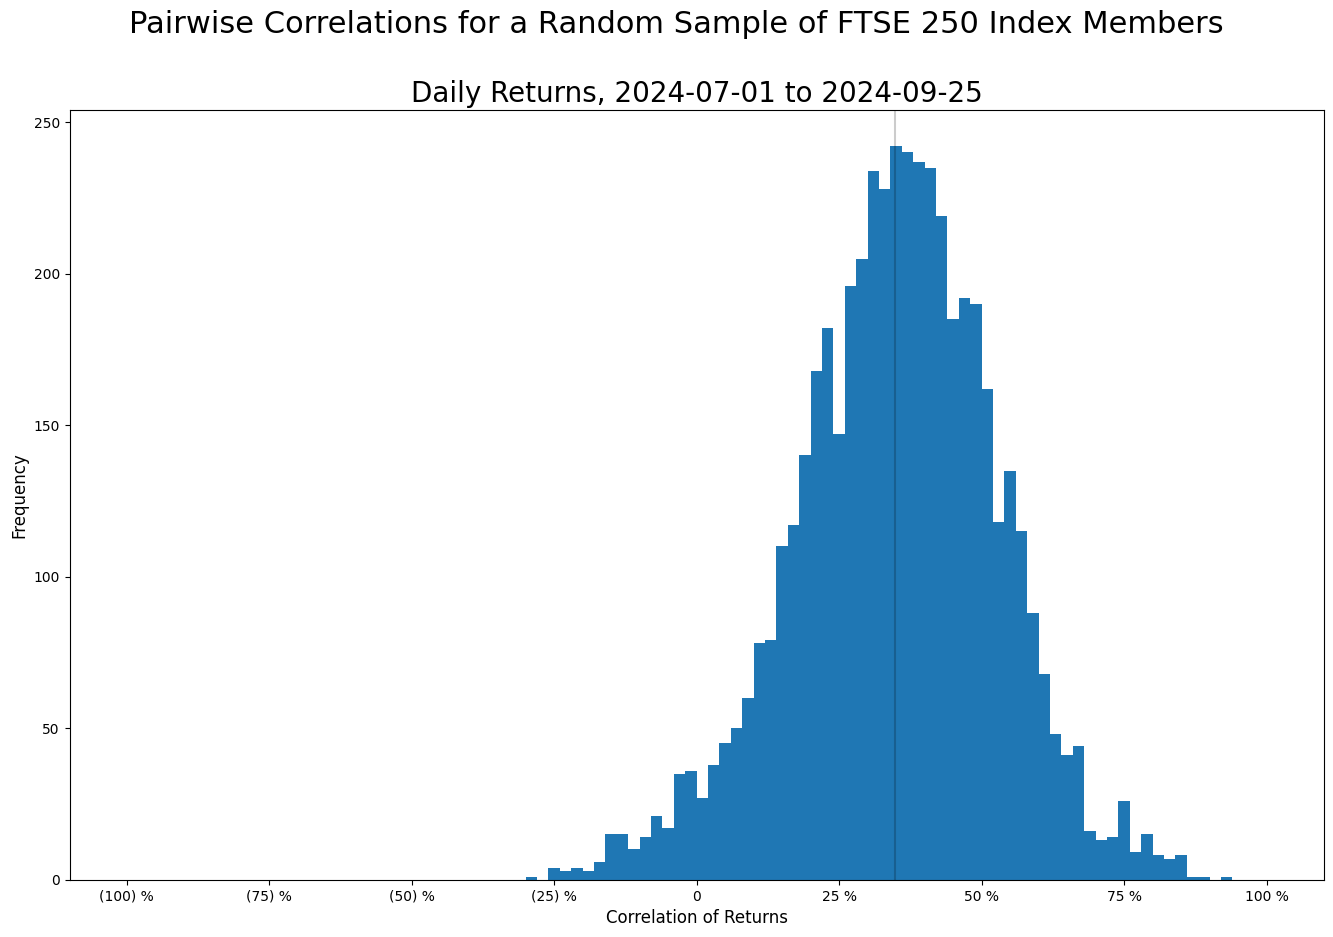

In [8]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
bins,counts,patches=plot.hist(results.loc[results.index!="Mean",'Correlation'].to_numpy(),bins=np.linspace(-hundred,hundred,101))
figure.suptitle(title:="Pairwise Correlations for a Random Sample of %s Index Members" % indexname,fontsize=22)
plot.set_title(subtitle:="Daily Returns, %s to %s" % (first_date,today("%Y-%m-%d")),fontsize=20)
plot.set_xlabel("Correlation of Returns",fontsize=12)
plot.xaxis.set_major_formatter(PercentLabels(0))
plot.set_ylabel("Frequency",fontsize=12)
plot.yaxis.set_major_formatter(CountLabels())
plot.axvline(m,color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

### Execute the $N^*$ vs. $N$ Analysis
---
$N^*$ is the effective degrees of freedom found within a portfolio of size $N$. This is computed by comparing the variance of the portfolio returns to the variance we would expect if all the stocks were independent.

In [23]:
results=pd.DataFrame({"Sample":range(1,(n:=1000)+1),"Assets":[np.nan]*n,"Portfolio":[np.nan]*n,"Stocks":[""]*n}).set_index("Sample") # n is number of trials
nprint("Getting daily data for all index stocks, starting on %s." % first_date)
closes=data['Adj Close']
closes.index=pd.DatetimeIndex(closes.index).to_period('B')

nprint("Beginning analysis for {:,d} trials.")

if (filter:=None) is not None: # choose "Up", "Down" or None
    nprint("Limiting analysis to portfolio %s days only." % filter.lower())
    #returns=closes.pct_change().iloc[1:]*hundred
    #select=returns.mean(axis=1)>zero if filter=='Up' else returns.mean(axis=1)<zero if filter=='Down' else ~returns.mean(axis=1).isna()

for i in tqdm(results.index): # for each trial, pick a random sample of stocks with portfolio sizes uniformly distributed between 1 and maximum, one of 2^503-1 choices
    returns=pd.DataFrame()

    for ticker in closes[np.random.choice(closes.columns,np.random.randint(1,closes.shape[1]+1),replace=False)]:
        returns[ticker]=closes[ticker].pct_change().dropna()*hundred # compute all adjusted returns, ticker by ticker

        if returns[ticker].shape[0]<1: # exclude time-series that are all NA's
            returns.drop(columns=ticker,inplace=True)

        else:
            returns=returns.copy() # 'cos it frags, apparently

    results.loc[i,"Stocks"]=",".join(returns.columns) # list of stocks in portfolio
    returns.drop(returns.index[-1],inplace=True) # get rid of final print in case unprocessed corporate actions exist
    returns['Portfolio']=returns.mean(axis=1) # equal weighted portfolio return
    select=returns["Portfolio"]>zero if filter=="Up" else returns["Portfolio"]<zero if filter=="Down" else ~returns["Portfolio"].isna()
    results.loc[i,"Assets"]=returns.shape[1]-1 # number of assets we ended up with
    results.loc[i,"Independent"]=returns.loc[select,[a for a in returns if a!="Portfolio"]].var().sum()/results.loc[i,"Assets"]**2 # if no correlation, portfolio variance is total variance divided by square of number of assets
    results.loc[i,"Portfolio"]=returns.loc[select,'Portfolio'].var() # variance of portfolio returns for same period as individual returns

results.dropna(inplace=True)
results["Effective D.o.F."]=results["Independent"]/results["Portfolio"]*results["Assets"]
display(results)
nprint("Done.")

15:39:28 Getting daily data for all index stocks, starting on 2024-07-01.
15:39:28 Beginning analysis for 1,000 trials. This may take about 7.0 minutes...


  0%|          | 0/1000 [00:00<?, ?it/s]

,Assets,Portfolio,Stocks,Independent,Effective D.o.F.
Sample,,,,,
1,31.0,0.912865,"AML.L,EOT.L,EMG.L,RICA.L,FAN.L,RWI.L,HAS.L,BRS...",0.085173,2.892398
2,47.0,0.855877,"HICL.L,CTY.L,VSVS.L,RCP.L,EWI.L,SPT.L,BREE.L,V...",0.049026,2.692237
3,130.0,0.985880,"INPP.L,ALPH.L,HGT.L,BLND.L,JTC.L,WG.L,RSW.L,MN...",0.027563,3.634538
4,162.0,0.843875,"DOM.L,TMPL.L,SRP.L,BLND.L,DRX.L,SDP.L,PNL.L,PZ...",0.019710,3.783772
5,232.0,0.918018,"VOF.L,KNOS.L,SVS.L,KLR.L,EMG.L,LWDB.L,HSL.L,SU...",0.014394,3.637664
...,...,...,...,...,...
996,102.0,1.042781,"DOCS.L,DRX.L,HAS.L,PHP.L,WIZZ.L,MGNS.L,ITV.L,S...",0.036277,3.548463
997,106.0,0.899332,"AML.L,BGFD.L,MYI.L,WWH.L,SPT.L,PPH.L,JII.L,FEM...",0.031418,3.703090
998,112.0,0.903479,"BRWM.L,ATG.L,CWK.L,FAN.L,PIN.L,FEV.L,AGR.L,IHP...",0.029003,3.595394


15:42:46 Done.


### Make a Plot

15:43:15 All Days: Effective D.o.F. Limit 3.64, Implied Correlation 27.18 %.


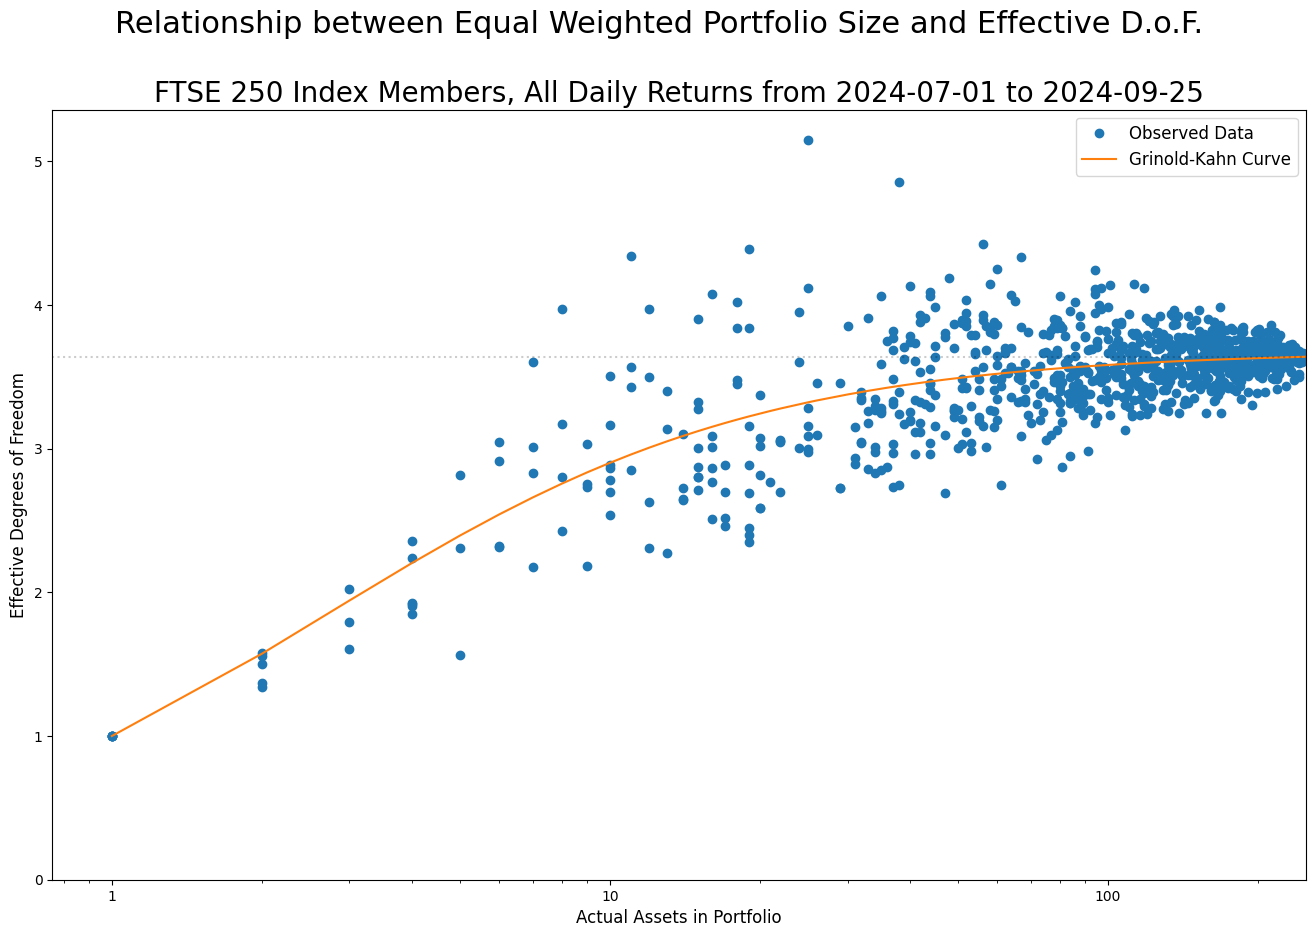

In [25]:
Nstar,Nact=tuple(results.sort_values("Assets").iloc[-1][["Effective D.o.F.","Assets"]])
rho=(Nact-Nstar)/((Nact-one)*Nstar)
nprint("{:s} Days: Effective D.o.F. Limit {:,.2f}, Implied Correlation {:.2f} %.".format(filter if filter is not None else "All",Nstar,rho*hundred))
meta=pd.concat([meta,pd.DataFrame({
    "Name":[(indexname,filter if filter is not None else "")],
     "N":[Nact],
    "N*":[Nstar],
    "rho":[rho]
}).set_index("Name")])

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.plot(x:=results["Assets"].to_numpy(),y:=results["Effective D.o.F."].to_numpy(),'o',label='Observed Data')
plot.plot(xp:=np.append([] if max(x)>100 else [zero],np.unique(np.sort(x))),xp/(one+(xp-one)*rho),'-',label='Grinold-Kahn Curve')
plot.set_xscale('log' if max(x)>100 else 'linear')
plot.set_ylim(zero,None)
plot.set_xlabel("Actual Assets in Portfolio",fontsize=12)
plot.set_ylabel("Effective Degrees of Freedom",fontsize=12)
figure.suptitle(title:="Relationship between Equal Weighted Portfolio Size and Effective D.o.F.",fontsize=22)
plot.set_title("%s Index Members, %s Daily Returns from %s to %s" % (indexname,filter if filter is not None else "All",first_date,pd.Timestamp.today().strftime("%Y-%m-%d")),fontsize=20)
plot.set_xlim(zero,index.shape[0])
plot.legend(fontsize=12)
plot.axhline(Nstar,color='black',linestyle=':',alpha=0.2)
plot.xaxis.set_major_formatter(CountLabels())
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

### Meta-Analysis
---

In [ ]:
meta.index=pd.MultiIndex.from_tuples(meta.index)
meta.index.names=("Name","Filter")
meta=meta.loc[~meta.index.duplicated(keep='last')]
display(meta.sort_values("N",ascending=True))

try:
    meta.to_pickle("/content/drive/MyDrive/meta.pickle")
    nprint("Saved meta-analysis results to Google Drive.")

except:
    raise RuntimeError("You need to mount your Google Drive to save results.")

In [ ]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.plot(x:=meta["N*"].to_numpy(),y:=meta["rho"].to_numpy()*hundred,'o',label='Observed Data',alpha=zero)
plot.set_xlabel("Effective Degrees of Freedom",fontsize=12)
plot.set_ylabel("Implied Correlation",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(0))
figure.suptitle(title:="Relationship between Effective D.o.F. and Implied Correlation",fontsize=22)
plot.set_title("Meta-Analysis of Survivorship Bias Free Index Studies",fontsize=20)
plot.set_xlim(np.floor(meta["N*"]).min()-one,np.ceil(meta["N*"]).max()+one)

for i in meta.index:
    plot.text(x:=meta.loc[i,"N*"],y:=meta.loc[i,"rho"]*hundred,s:="\n".join(i),ha='center',va='center',fontsize=10)

figure.savefig(title+".png",dpi=300,bbox_inches='tight')

### $\LaTeX$ Code for the Formulae in the Articles
---

$$
V_P=\mathbb{V}\!\left[\frac{1}{N}\sum_{i=1}^Nr_{it}\right]=\frac{1}{N^2}\mathbb{V}\!\left[\sum_{i=1}^Nr_{it}\right]
$$

$$
V_P=\frac{1}{N^2}\sum_{i=1}^N\sigma_i^2+\frac{2}{N^2}\sum_{i=1}^N\sum_{j=i+1}^N\sigma_i\sigma_j\rho_{ij}=V_I+V_C
$$

$$
V_I=\frac{1}{N}\left(\frac{1}{N}\sum_{i=1}^N\sigma_i^2\right)=\frac{\overline{\sigma^2}}{N}
$$

$$
\mathbb{V}[\bar{x}]=\frac{\sigma^2}{N}\;\mathrm{where}\;\mathbb{V}[x_i]=\mathbb{V}[x_j]=\sigma^2\;\mathrm{and}\;\mathbb{C}[x_i,x_j]=0\;\forall\;i,j
$$

$$
V_P=V_I\left(1+\frac{V_C}{V_I}\right)=\frac{\overline{\sigma^2}}{N}\left(1+\frac{V_C}{V_I}\right)
$$

$$
V_P=\frac{\overline{\sigma^2}}{N^*}\;\mathrm{where}\;N^*=N\frac{V_I}{V_P}
$$

$$
\sum_{N=1}^M\begin{pmatrix}M\\ N\end{pmatrix}=2^M-1
$$

$$
2^{503}-1\approx3.3\times10^{150}
$$

$$
\mathbb{V}[r_{it},r_{jt}]=\sigma_{it}\sigma_{jt}\rho\;\Leftrightarrow\;V_t=S_tRS_t\;\mathrm{where}\;R=\begin{pmatrix}
1&\rho&\cdots&\rho\\
\rho&1&\cdots&\rho\\
\vdots&&\ddots&\vdots\\
\rho&\rho&\cdots&1
\end{pmatrix}\;\mathrm{and}\;
S_t=\begin{pmatrix}
\sigma_{1t}&0&\cdots&0\\
0&\sigma_{2t}&\cdots&0\\
\vdots&&\ddots&\vdots\\
0&0&\cdots&\sigma_{Nt}
\end{pmatrix}
$$

In [ ]:
meta.xs('',axis=0,level=1)